In [1]:
#pip install catboost <- run first time this notebook is executed

In [2]:
import pandas as pd
from catboost import CatBoostRegressor
import datetime
from sklearn import preprocessing
import numpy as np
from matplotlib import pyplot as plt

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_parquet('dataframe_prophet_format.parquet')

In [5]:
df.set_index('Date', inplace=True)

In [6]:
def predict_horizon(model, training_df, test_df, feature_list, num_predictions=8):
    start_period = 0
    end_period = num_predictions
    prediction_list = []
    MAPE_list = []
    
    # We generate an encoder for ns feature
    if 'Country' in feature_list:
        ns_encoder = preprocessing.LabelEncoder()
        training_df['Country'] =  ns_encoder.fit_transform(training_df['Country'])
    
    x_training_df = training_df[feature_list].copy()
    y_training_df = training_df['Cases'].copy().to_frame()
    model.fit(x_training_df, np.ravel(y_training_df))
    
    # Predicting on test set, while end period is not equal to end of length of test_df
    while end_period <= len(test_df):
        # Collect features from start to end (67 hours) and predict
        features_df = test_df[feature_list][start_period:end_period].copy()
        if 'Country' in feature_list:
            features_df['Country'] = ns_encoder.transform(features_df['Country'])
        true_df = test_df[['Cases']][start_period:end_period].copy()
        predictions = model.predict(features_df)
       
        # Add the predicted data
        predicted_df = pd.DataFrame(predictions, columns=['predicted'])
        predicted_df.index = true_df.index.copy()        
        prediction_list.extend(predictions)
        # Calculate MAPE per prediction (hour) and MAPE per horizon
        MAPE_list.extend(MAPE(true_df, predicted_df, whole_horizon=False))
        # Move to next period
        start_period += 1
        end_period += 1
    
    test_df = test_df.assign(Predicted=prediction_list)
    test_df = test_df.assign(MAPE_values=MAPE_list)    
    return test_df


In [7]:
def MAPE(true_df, predicted_df, column_name = 'Cases', whole_horizon=True):
    """""Mean absolute percent error
    Parameters
    ----------
    true_df         : a Dataframe with observed/true values
    predicted_df    : a Dataframe with predicted values
    column_name     : name of the column in the DF with the true/predicted values (assuming same name)
 
    Returns
    -------
    If whole_horizon==True, a unique MAPE value for the whole horizon
    If whole_horizon==False, a vector of MAPE values for each hour of the predicted horizon
    """
    # Check for zero values in the true vector
    if true_df[column_name].isin([0]).any():
            print('True_df contains a 0 error, will result in nan in MAPE')
    # 
    sum_observed = true_df['Cases'].sum()
    abs_error_predicted = np.abs(true_df['Cases']-predicted_df['predicted'])
    #
    if whole_horizon == True:
        MAPE = 100 * abs_error_predicted.sum() / sum_observed
    else:
        MAPE = 100 * abs_error_predicted / (sum_observed/len(true_df))
    #
    return MAPE

In [8]:
def true_predicted_fig(true_df, predicted_df, title_str):
    fig,ax = plt.subplots(figsize=[12,4])
    p_t_max = np.max(np.maximum(true_df[:8]['Cases'].values,predicted_df[:8]['Predicted'].values))
    p_t_min = np.min(np.minimum(true_df[:8]['Cases'].values,predicted_df[:8]['Predicted'].values))
    t1 = ax.plot(true_df.index[:8], true_df[:8]['Cases'], 'black')
    ax.set_ylabel('Cases')
    ax.tick_params(axis='x', rotation=45)
    ax.set_title(title_str)
    p1 = ax.plot(predicted_df.index[:8], predicted_df[:8]['Predicted'], 'Red', linewidth=3)
    ax.legend((t1[0], p1[0]), ('True', 'Predicted'), loc=1, frameon=True)
    #ax.set_ylim(p_t_min-0.1*p_t_min, p_t_max+0.1*p_t_min)


## K-means z trans, cluster 1

In [9]:
cluster_1_countries = pd.read_parquet('../common/clustering_results/df_kmeans_z_0.parquet')

In [10]:
cluster_1_countries_list = list(cluster_1_countries.columns)

In [11]:
cluster_1_countries_list.remove('Ecuador')

In [12]:
df_1 = df[df['Country'].isin(cluster_1_countries_list)]

In [13]:
#Add feature

In [14]:
df_1['Month'] = df_1.index.month
df_1['Day'] = df_1.index.weekday

In [15]:
df_1['prev_case'] = df_1['Cases'].shift(periods=1)

In [16]:
startDate = datetime.datetime(2020, 3, 1)

In [17]:
df_1.prev_case[df_1.index==startDate] = 0

In [19]:
df_1_Bangladesh = df[df['Country'].isin(['Bangladesh'])]

In [20]:
df_1_Bangladesh['Month'] = df_1_Bangladesh.index.month
df_1_Bangladesh['Day'] = df_1_Bangladesh.index.weekday

In [21]:
df_1_Bangladesh['prev_case'] = df_1_Bangladesh['Cases'].shift(periods=1)

In [22]:
df_1_Bangladesh.prev_case[df_1_Bangladesh.index==startDate] = 0

In [24]:
cluster_1_training_df = df_1[(df_1.index.date >= datetime.date(2020, 3, 1)) & 
                    (df_1.index.date <= datetime.date(2020, 9, 9))].copy()

In [25]:
cluster_1_test_df =  df_1_Bangladesh[(df_1_Bangladesh.index.date > datetime.date(2020, 9, 9)) & 
                    (df_1_Bangladesh.index.date <= datetime.date(2020, 9, 17))].copy()

In [26]:
# Generate model
feature_list = ['Country','Month','Day','prev_case']
params= {'iterations': 5000, 'silent': True}
model = CatBoostRegressor(**params)
cluster1_CB_df = predict_horizon(model=model, training_df=cluster_1_training_df.copy(), 
                                                             test_df=cluster_1_test_df.copy(),
                                                             feature_list=feature_list)



In [27]:
cluster1_CB_df

,Cases,Country,Month,Day,prev_case,Weekday,Predicted,MAPE_values
Date,,,,,,,,
2020-09-10,331078.0,Bangladesh,9,3,329251.0,0.0,328057.667836,0.896430
2020-09-11,332970.0,Bangladesh,9,4,331078.0,0.0,327758.402851,1.546793
2020-09-12,334762.0,Bangladesh,9,5,332970.0,1.0,339421.869023,1.383041
2020-09-13,336044.0,Bangladesh,9,6,334762.0,1.0,338934.856543,0.858001
2020-09-14,337520.0,Bangladesh,9,0,336044.0,0.0,337570.427630,0.014967
2020-09-15,339332.0,Bangladesh,9,1,337520.0,0.0,339404.200454,0.021429
2020-09-16,341056.0,Bangladesh,9,2,339332.0,0.0,340570.509626,0.144093
2020-09-17,342671.0,Bangladesh,9,3,341056.0,0.0,339943.280431,0.809583


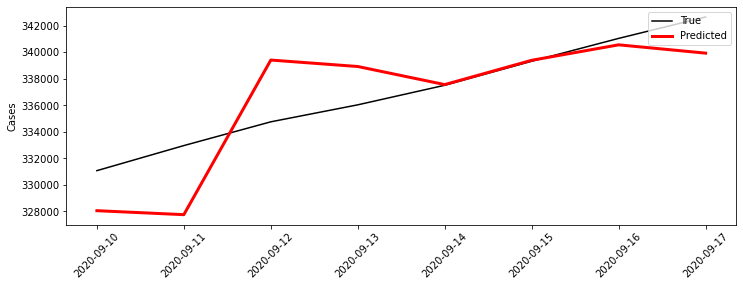

In [28]:
title_str =''
true_predicted_fig(cluster_1_test_df,cluster1_CB_df,title_str)